# <center>BÁO CÁO SEMINAR CHỦ ĐỀ FACT-CHECKING AND MISINFORMATION DETECTION </center>

In [1]:
!pip install transformers

In [2]:
from google.colab import drive
import json
from transformers import AutoModel, AutoTokenizer
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import json

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!unzip "/content/drive/MyDrive/Data/UIT-ISE Dataset.zip"

Archive:  /content/drive/MyDrive/Data/UIT-ISE Dataset.zip
   creating: UIT-ISE Dataset/.ipynb_checkpoints/
  inflating: UIT-ISE Dataset/ise-dsc01-warmup.json  
  inflating: UIT-ISE Dataset/ise-dsc01-public-test-offcial.json  
  inflating: UIT-ISE Dataset/public_result.json  
  inflating: UIT-ISE Dataset/ise-dsc01-train.json  


In [4]:
train_path = '/content/UIT-ISE Dataset/ise-dsc01-train.json'
with open(train_path, 'r') as file:
    data = json.load(file)

In [5]:
import pandas as pd
df = pd.DataFrame.from_dict(data, orient='index')
df.reset_index(inplace=True)
df.rename(columns={'index': 'id'}, inplace=True)

In [6]:
# Kiểm tra data sau khi đọc từ json
df.head()

,id,context,claim,verdict,evidence,domain
0,7125,"Phát biểu tại lễ ký kết vào ngày 17/11, Giám đ...","Ngoài việc không giới hạn mức lương, công ty c...",SUPPORTED,"Công ty cũng có chế độ đãi ngộ tốt, có lương t...",giao-duc
1,7126,"Phát biểu tại lễ ký kết vào ngày 17/11, Giám đ...","Thành lập năm 2016, phát triển phần mềm, tổ ch...",SUPPORTED,"FABA Technology thành lập năm 2016, chuyên cun...",giao-duc
2,7127,"Phát biểu tại lễ ký kết vào ngày 17/11, Giám đ...","Nhằm phát triển đội ngũ, FABA thường tổ chức n...",SUPPORTED,"Bên cạnh đó, FABA thường xuyên tổ chức những d...",giao-duc
3,7128,"Đối với các nhà khoa học, trí thức, điều kiện ...",Sở dĩ vị trí kỹ sư phần mềm có mức lương cao n...,SUPPORTED,"Theo Adeco Việt Nam, mức lương cao nhất đối vớ...",giao-duc
4,7129,"Đối với các nhà khoa học, trí thức, điều kiện ...","Theo Adeco Việt Nam, mức lương cao nhất đối vớ...",SUPPORTED,"Trong khi đó, theo báo cáo ""Thị trường nhân lự...",giao-duc


In [7]:
# Splitting the DataFrame into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2)

In [8]:
phobert = AutoModel.from_pretrained("vinai/phobert-base")
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/895k [00:00<?, ?B/s]

bpe.codes:   0%|          | 0.00/1.14M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.13M [00:00<?, ?B/s]

# Sentence Retriveal

Ta nhập Input bao gồm *Domain*, *Context* và *Claim* để truy xuất ra câu evidence liên quan nhất đến *Claim*

In [11]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch
from torch.nn.functional import cosine_similarity
from nltk.tokenize import sent_tokenize


def calculate_similarity(embedding1, embedding2):
    return cosine_similarity(embedding1, embedding2, dim=1)

def split_context_into_sentences(context):
    return sent_tokenize(context)

def get_claim_embedding(claim, model, tokenizer, device):
    inputs = tokenizer.encode_plus(
        claim,
        add_special_tokens=True,
        max_length=512,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
    )
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        output = model(**inputs)
    claim_embedding = output.last_hidden_state[:, 0, :]
    return claim_embedding

tokenizer = AutoTokenizer.from_pretrained('vinai/phobert-base')
model = AutoModel.from_pretrained('vinai/phobert-base')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

context = "PGS.TS Nguyễn Quang Liệu, hiệu trưởng trường THPT chuyên Khoa học Xã hội và Nhân văn, hôm 15/5 cho biết có 1.579 thí sinh đăng ký vào ba lớp chuyên của trường, trong khi chỉ tiêu là 136.\n\nLớp chuyên Ngữ văn có 970 học sinh đăng ký - cao nhất từ trước đến nay. Với chỉ tiêu 66, lớp này có tỷ lệ chọi 1/14,7, tăng so với mức 1/9 của năm ngoái. Như vậy, tính trung bình thì cứ 15 thí sinh mới có một em trúng tuyển.\n\nHai lớp chuyên Lịch sử và Địa lý cùng tuyển 35 học sinh, lần lượt nhận 317 và 292 hồ sơ, tỷ lệ chọi là 1/9,05 và 1/8,3, cũng tăng so với năm 2022.\n\nNgoài ba lớp chuyên, trường tuyển 34 học sinh hệ chất lượng cao.\n\nTất cả thí sinh phải làm bốn bài thi viết hôm 4/6, gồm Ngữ văn, Toán, Tiếng Anh và môn chuyên. Trong đó, đề môn Ngữ văn và môn chuyên theo hình thức tự luận, thời gian làm bài lần lượt 90 và 150 phút. Thí sinh thi trắc nghiệm môn Toán trong 50 phút và Tiếng Anh 45 phút. Lệ phí đăng ký và thi tuyển là 460.000 đồng.\n\nĐiểm xét tuyển là tổng điểm các môn thi theo thang điểm 10, môn chuyên nhân hệ số hai. Trường không cộng điểm ưu tiên trong tuyển sinh, không xét tuyển thẳng.\n\nKết quả xét tuyển vào các lớp chuyên sẽ được công bố trước ngày 1/7. Với lớp chất lượng cao, trường tuyển từ những thí sinh không trúng tuyển hệ chuyên, có điểm thi từng môn đạt từ 4 trở lên và có đăng ký xét tuyển vào lớp chất lượng cao. Điểm xét tuyển vào lớp này là tổng ba môn chung, không tính môn chuyên.\n\nTrường THPT chuyên Khoa học Xã hội và Nhân văn được thành lập tháng 10/2019. Đây là trường THPT thứ tư trực thuộc Đại học Quốc gia Hà Nội, chịu sự quản lý trực tiếp của trường Đại học Khoa học Xã hội và Nhân văn.\n\nNăm ngoái, trường THPT chuyên Khoa học Xã hội và Nhân văn tuyển 180 học sinh, thu hút hơn 1.000 thí sinh tham dự. Điểm chuẩn với lớp chuyên Ngữ văn là 33,5, hai lớp Địa lý và Lịch sử lần lượt lấy 28,5 và 28, trung bình 5,6-6,7 điểm mỗi môn.\n\nThanh Hằng"
claim = "Điểm xét tuyển là tổng điểm các môn thi theo thang điểm 10, môn chuyên nhân hệ số hai, không cộng điểm ưu tiên, không tuyển thẳng"
top_k = 5

sentences = split_context_into_sentences(context)
evidence_scores = {}
claim_embedding = get_claim_embedding(claim, model, tokenizer, device)

for sentence in sentences:
    inputs = tokenizer(sentence, return_tensors='pt', padding=True, truncation=True)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
    sentence_claim_embedding = outputs.last_hidden_state[:, 0, :]
    similarity_score = calculate_similarity(sentence_claim_embedding, claim_embedding)
    evidence_scores[sentence] = similarity_score.item()

sorted_evidence = sorted(evidence_scores.items(), key=lambda item: item[1], reverse=True)
top_evidence_sentences = [sentence for sentence, score in sorted_evidence[:top_k]]


In [13]:
top_evidence_sentences

['Điểm xét tuyển là tổng điểm các môn thi theo thang điểm 10, môn chuyên nhân hệ số hai.',
 'Điểm xét tuyển vào lớp này là tổng ba môn chung, không tính môn chuyên.',
 'Trong đó, đề môn Ngữ văn và môn chuyên theo hình thức tự luận, thời gian làm bài lần lượt 90 và 150 phút.',
 'Trường không cộng điểm ưu tiên trong tuyển sinh, không xét tuyển thẳng.',
 'Như vậy, tính trung bình thì cứ 15 thí sinh mới có một em trúng tuyển.']

# Verdict Prediction

## Xây dựng model Verdict Prediction với PhoBERT

In [14]:
class FactCheckDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=256):
        self.dataframe = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        inputs = self.tokenizer.encode_plus(
            row['claim'],
            row['evidence'],
            add_special_tokens=True,
            max_length=self.max_length,
            padding='max_length',
            return_token_type_ids=False,
            return_attention_mask=True,
            truncation=True,
            return_tensors="pt"
        )
        labels = torch.tensor(1 if row['verdict'] == 'SUPPORTED' else 0, dtype=torch.long)
        return inputs.input_ids, inputs.attention_mask, labels

In [15]:
class PhoBERTClassifier(nn.Module):
    def __init__(self, phobert):
        super(PhoBERTClassifier, self).__init__()
        self.phobert = phobert
        self.classifier = nn.Linear(phobert.config.hidden_size, 2) # 2 classes

    def forward(self, input_ids, attention_mask):
        outputs = self.phobert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        return self.classifier(pooled_output)

model = PhoBERTClassifier(phobert)

In [16]:
batch_size = 32
train_dataset = FactCheckDataset(train_df, tokenizer)
test_dataset = FactCheckDataset(test_df, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [17]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = PhoBERTClassifier(phobert).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=5e-5)

In [18]:
def train_model(model, train_loader, criterion, optimizer, num_epochs):
    model.train()  # Set the model to training mode

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        progress_bar = tqdm(enumerate(train_loader), total=len(train_loader))

        for i, (inputs, attention_mask, labels) in progress_bar:
            inputs, attention_mask, labels = inputs.to(device), attention_mask.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs.squeeze(1), attention_mask.squeeze(1))
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()
            progress_bar.set_description(f"Epoch {epoch+1}/{num_epochs}")
            progress_bar.set_postfix(loss=epoch_loss/(i+1))

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(train_loader):.4f}")


In [19]:
num_epochs = 3
train_model(model, train_loader, criterion, optimizer, num_epochs)

Epoch 1/3: 100%|██████████| 950/950 [20:47<00:00,  1.31s/it, loss=0.235]


Epoch 1/3, Loss: 0.2354


Epoch 2/3: 100%|██████████| 950/950 [20:48<00:00,  1.31s/it, loss=0.117]


Epoch 2/3, Loss: 0.1170


Epoch 3/3: 100%|██████████| 950/950 [20:48<00:00,  1.31s/it, loss=0.0718]

Epoch 3/3, Loss: 0.0718


In [20]:
# Save model
torch.save(model, 'verdict_pred_model.pth')

## Đánh giá model

In [21]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the entire model
loaded_model = torch.load('verdict_pred_model.pth', map_location=device)

# Set the loaded_model to evaluation mode
loaded_model.eval()

PhoBERTClassifier(
  (phobert): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): L

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def get_predictions_and_labels(model, data_loader, device):
    model.eval()
    predictions = []
    labels = []

    with torch.no_grad():
        for inputs, attention_mask, label in data_loader:
            inputs, attention_mask, label = inputs.to(device), attention_mask.to(device), label.to(device)

            outputs = model(inputs.squeeze(1), attention_mask.squeeze(1))
            _, predicted = torch.max(outputs, dim=1)

            predictions.extend(predicted.cpu().numpy())
            labels.extend(label.cpu().numpy())

    return predictions, labels

predictions, labels = get_predictions_and_labels(loaded_model, test_loader, device)

              precision    recall  f1-score   support

     REFUTED       0.96      0.97      0.97      5005
   SUPPORTED       0.95      0.93      0.94      2589

    accuracy                           0.96      7594
   macro avg       0.96      0.95      0.95      7594
weighted avg       0.96      0.96      0.96      7594



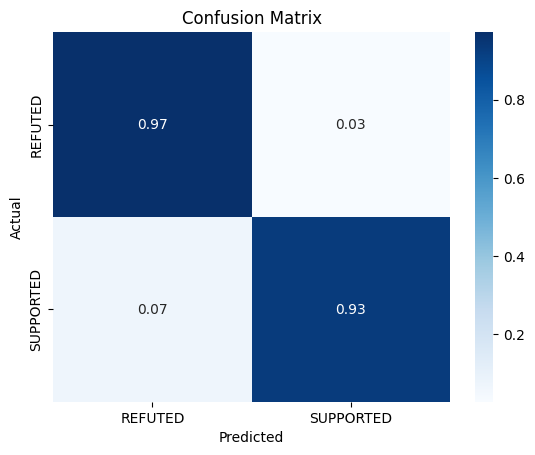

In [23]:
from sklearn.metrics import classification_report

def get_classification_report(labels, predictions):
    performance_report = classification_report(labels, predictions, target_names=['REFUTED', 'SUPPORTED'])
    print(performance_report)

def plot_confusion_matrix(labels, predictions):
    cm = confusion_matrix(labels, predictions, normalize='true')
    sns.heatmap(cm, annot=True, fmt=".2f", cmap='Blues', xticklabels=['REFUTED', 'SUPPORTED'], yticklabels=['REFUTED', 'SUPPORTED'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('Confusion Matrix')
    plt.show()

get_classification_report(labels, predictions)
plot_confusion_matrix(labels, predictions)

In [24]:
def test_model_result(model, new_claim, new_evidence):
    model.eval()
    with torch.no_grad():
        if len(new_evidence)==0:
            print("NEI")
            return
        # Tokenize new data
        new_inputs = tokenizer.encode_plus(new_claim, new_evidence, return_tensors='pt', padding=True, truncation=True, max_length=256)
        new_inputs = {key: val.to(device) for key, val in new_inputs.items()}

        # Predict
        new_outputs = model(new_inputs['input_ids'].squeeze(1), new_inputs['attention_mask'].squeeze(1))
        new_prediction = torch.argmax(new_outputs, dim=1)

        # Interpret the prediction
        print("Prediction:", "SUPPORTED" if new_prediction.item() == 1 else "REFUTED")

In [25]:
new_claim = "Cuộc tranh cãi còn chưa dứt về số tài liệu mật được Cục Điều tra Liên bang Mỹ (FBI) thu hồi từ dinh thự Mar-a-Lago của cựu tổng thống Donald Trump hồi năm ngoái thì trong tuần này chính trường Mỹ lại náo động về những tài liệu đóng dấu mật không được bảo quản đúng nơi quy định"
new_evidence = "Trong khi tranh cãi còn chưa dứt về số tài liệu mật được Cục Điều tra Liên bang Mỹ (FBI) thu hồi từ dinh thự Mar-a-Lago của cựu tổng thống Donald Trump hồi năm ngoái, chính trường Mỹ tuần này lại một lần nữa xôn xao về những tài liệu đóng dấu mật không được bảo quản đúng nơi quy định"
test_model_result(loaded_model, new_claim, new_evidence)

Prediction: SUPPORTED
